## Notebook settings

In [3]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

## Imports

In [6]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
import logging
import tpvalidator.mcprod.workspace as workspace
import tpvalidator.utilities as utils
import tpvalidator.mcprod.analyzers.snn as snn

from rich import print
from tpvalidator.utilities import temporary_log_level, subplot_autogrid, pandas_backend
from tpvalidator.histograms import uproot_hist_mean_std


# Code

In [59]:

def draw_bt_eff_by_plane(ws, rop_id, ax, filter: str=None):
    rop_code = {
        0: 'U',
        1: 'V',
        2: 'X',
    }
    tot_nel_df = ws.event_summary[['event', f'tot_numelectrons_{rop_code[rop_id]}']].set_index('event')
    tps = ws.tps.query(f'bt_is_signal == 1 & readout_plane_id == {rop_id}')
    if filter:
        tps = tps.query(filter)
    bt_nel_df = pd.DataFrame(tps.groupby('event').bt_numelectrons.sum())
    eff_df = tot_nel_df.merge(bt_nel_df, how='inner', on='event').fillna(0)
    eff_df['ratio'] = eff_df.bt_numelectrons/eff_df[f'tot_numelectrons_{rop_code[rop_id]}']
    eff_df.ratio.hist(ax=ax)
    return eff_df

# Load ADC mean and standard deviation from wafevorm histograms

In [8]:
with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.INFO):
    ws = workspace.TriggerPrimitivesWorkspace("../../data/vd/ar39/100events/trigtree_tpg_vd_ar39.root")

print(ws.info)

INFO:TriggerPrimitivesWorkspace:tpmakerTPCSimpleThreshold__TriggerPrimitiveMaker found with 72540769 rows


{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 23,
            'threshold_tpg_plane1': 23,
            'threshold_tpg_plane2': 26,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

In [9]:
ws.add_rawdigits('../../data/vd/ar39/100events/trigger_digits_waves_detsim_vd_ar39.root')

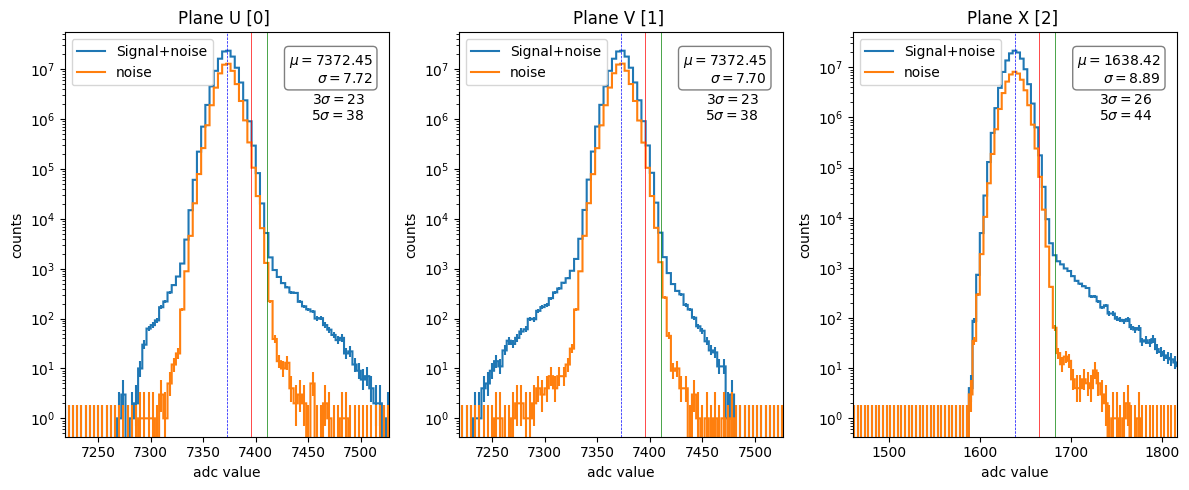

In [10]:
fig = snn.draw_signal_and_noise_adc_distros(ws)
fig.tight_layout()

# TP validation


In [15]:
all_tps = snn.TPSignalNoisePreSelection(ws.tps)
alltp_ana = snn.TPSignalNoiseAnalyzer(all_tps)

## Distribution of point of origin in the detector

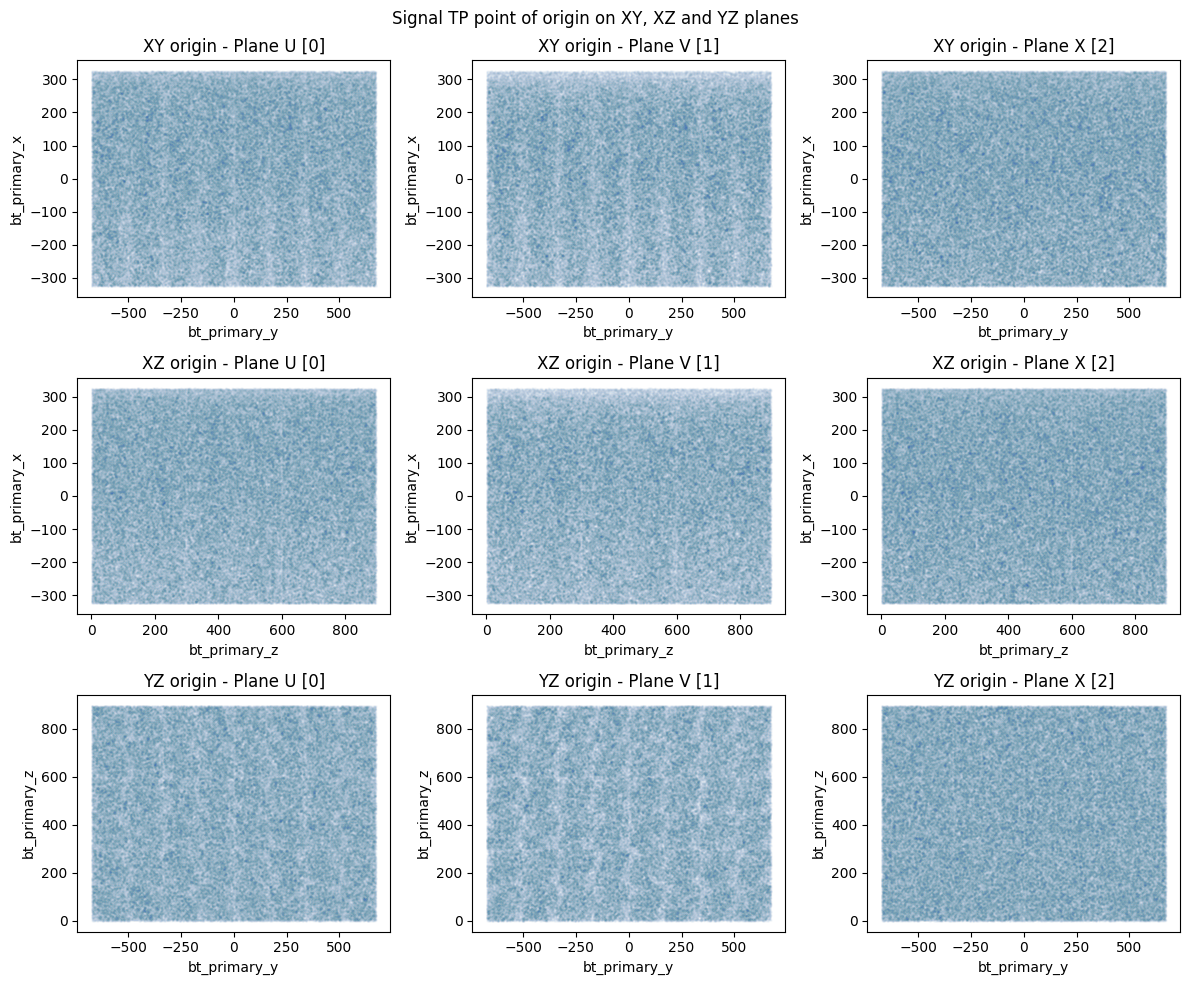

In [16]:
fig = alltp_ana.draw_tp_sig_origin_2d_dist()
fig.tight_layout()

In [17]:
pd.options.plotting.backend = 'plotly'
import plotly.express as px
# ws.tps.query('event == 1 & TP_peakADC > 50').plot.scatter(x='TP_channel', y='TP_peakT', size='TP_peakADC', color_continuous_scale=px.colors.sequential.Viridis, height=500, width=600)

pd.options.plotting.backend = 'matplotlib'
with pandas_backend('plotly') as x:
    f = ws.tps.query('event == 1 & readout_view==2').plot.scatter(x='channel', y='time_start', size='adc_peak', color="bt_is_signal", color_continuous_scale=px.colors.sequential.Viridis, height=800, width=900)
    f.show()


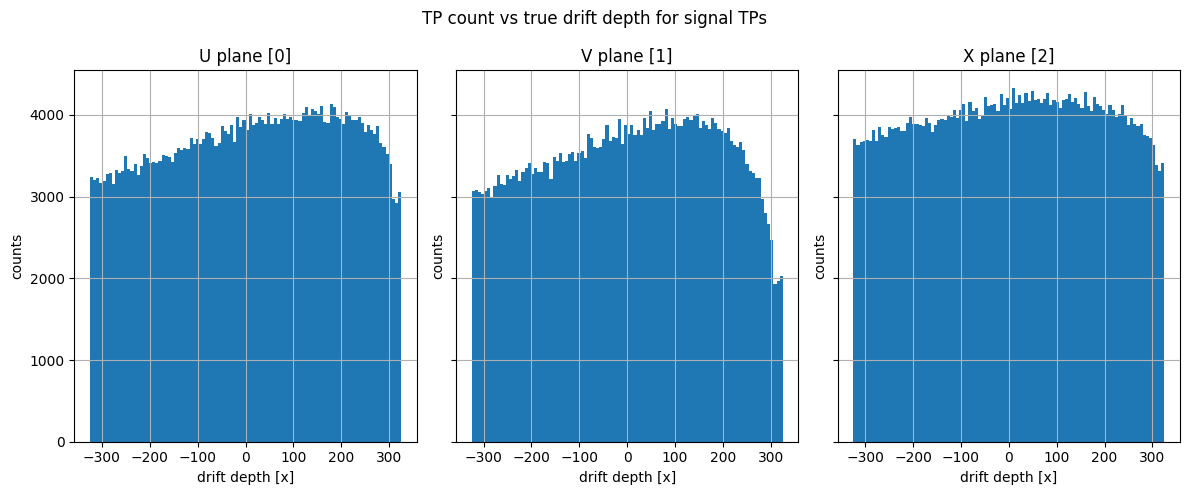

In [18]:
fig = alltp_ana.draw_tp_sig_drift_depth_dist()

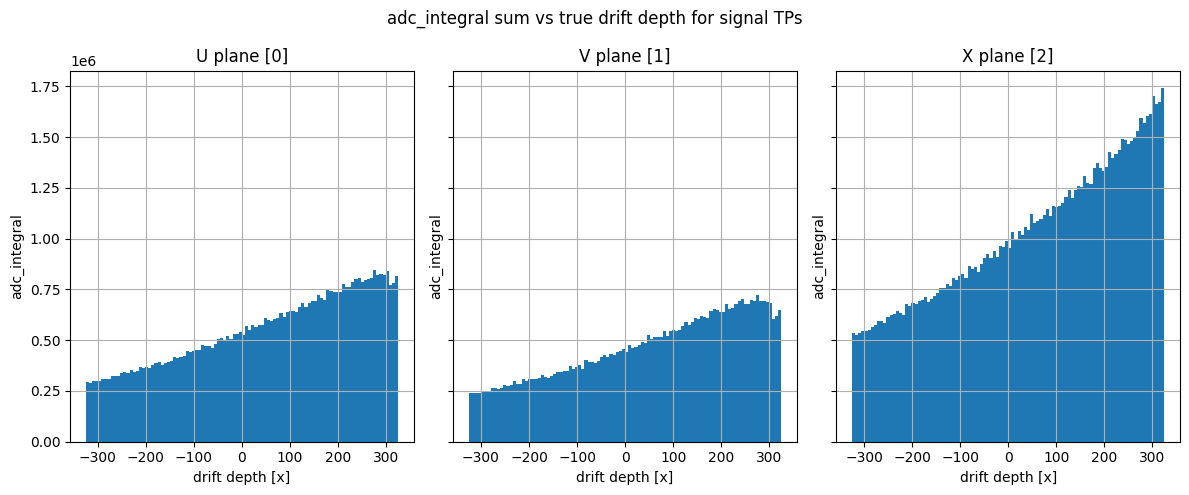

In [19]:
fig = alltp_ana.draw_tp_sig_drift_depth_dist(weight_by='adc_integral')

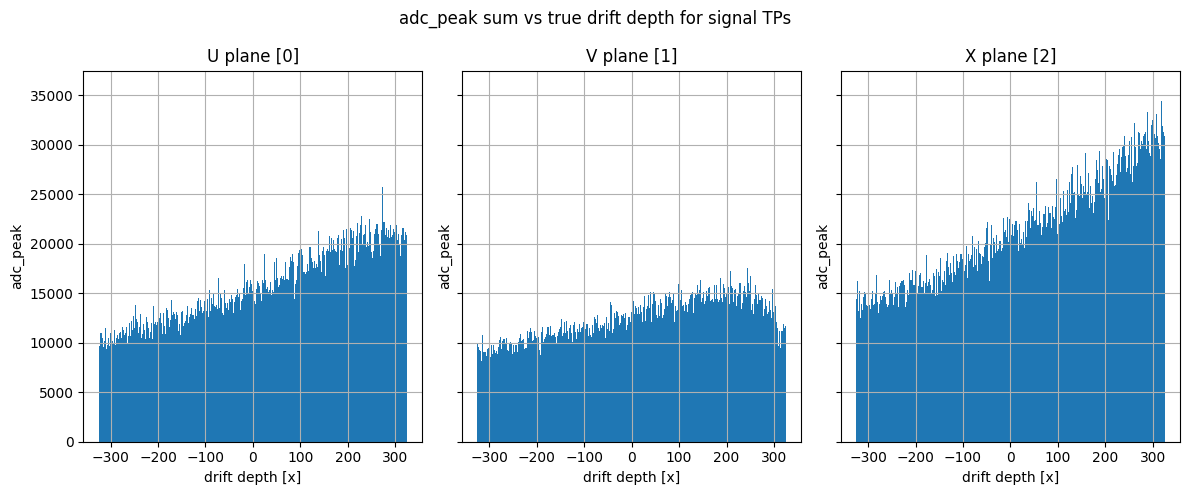

In [20]:
fig = alltp_ana.draw_tp_sig_drift_depth_dist(weight_by='adc_peak', bins=1000)

# Dataset validation: TP distributions

### TP distribution in channel and time - one event with increasing peak ADC cuts

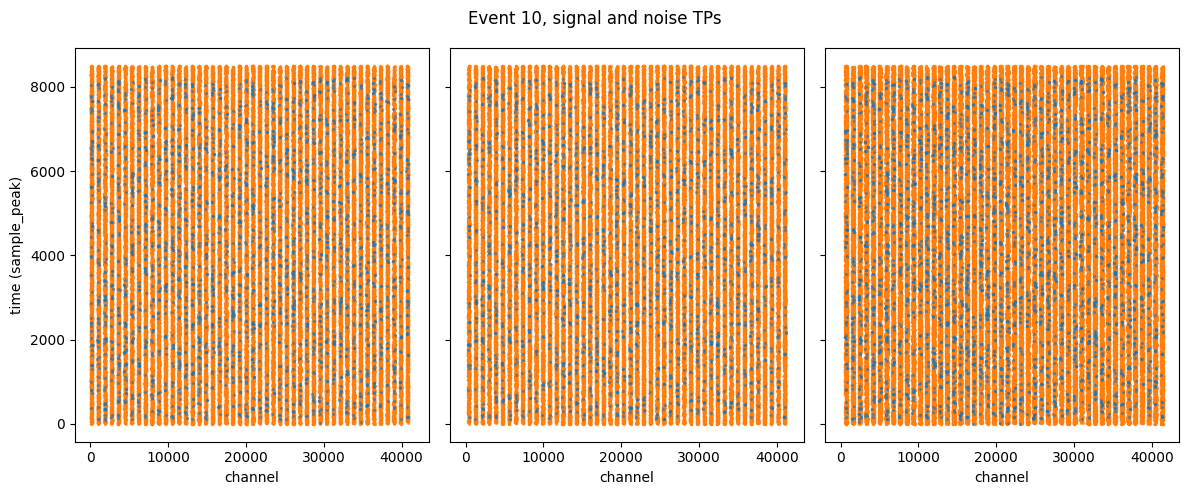

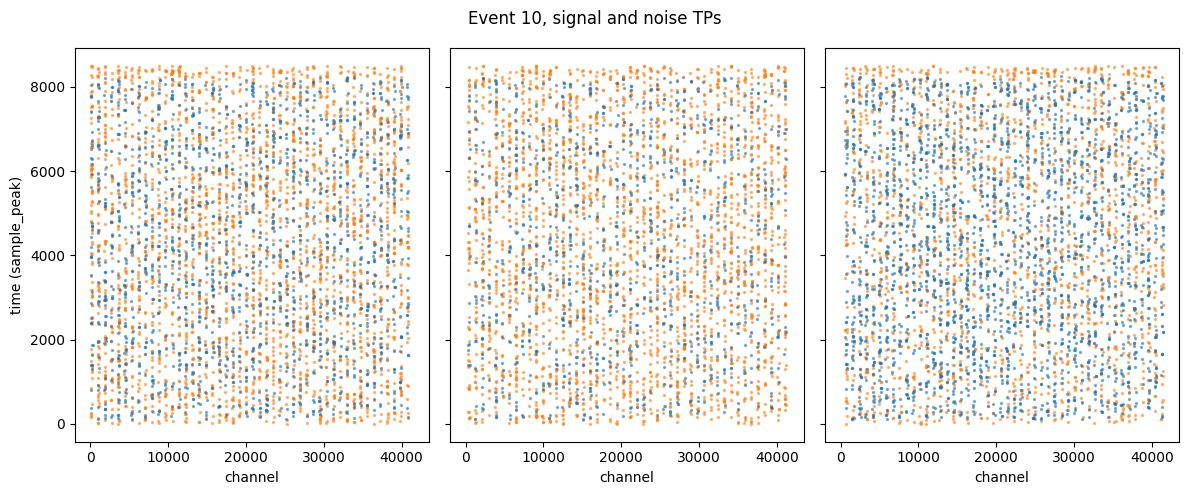

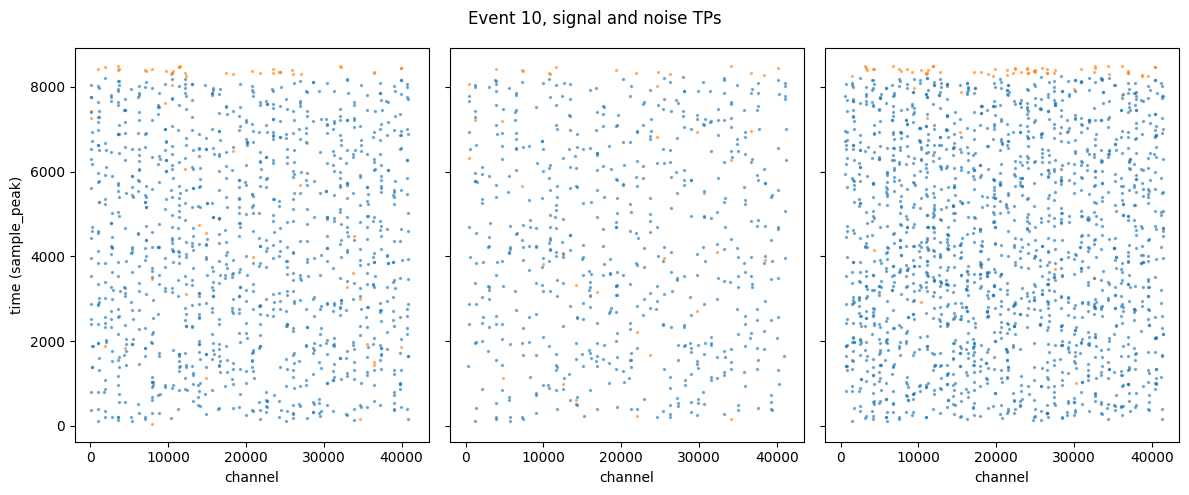

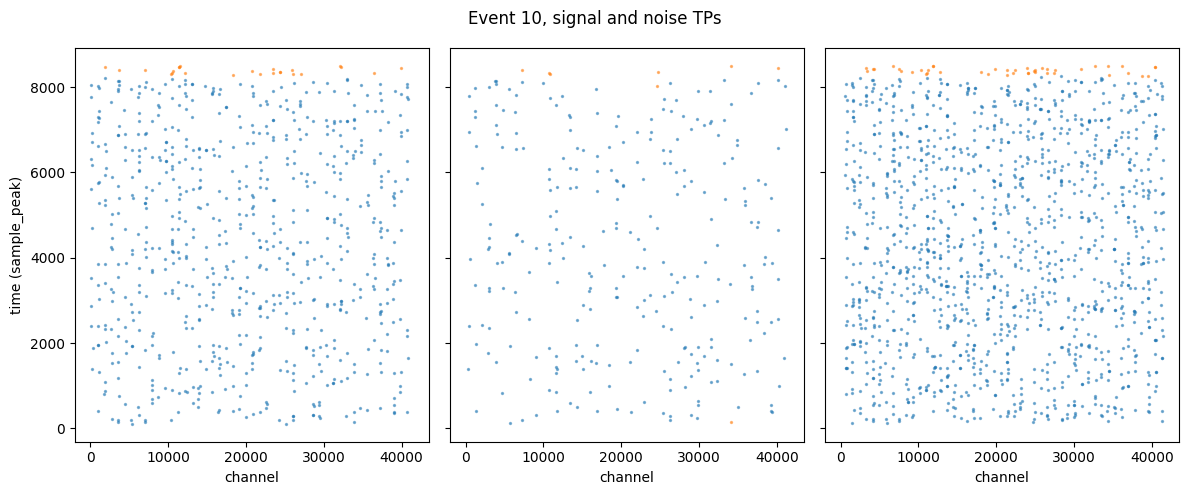

In [21]:
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 26'))
fig = x.draw_tp_event(10)
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 36'))
fig = x.draw_tp_event(10)
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 46'))
fig = x.draw_tp_event(10)
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 56'))
fig = x.draw_tp_event(10)


### TP distribution in channel and time - all events

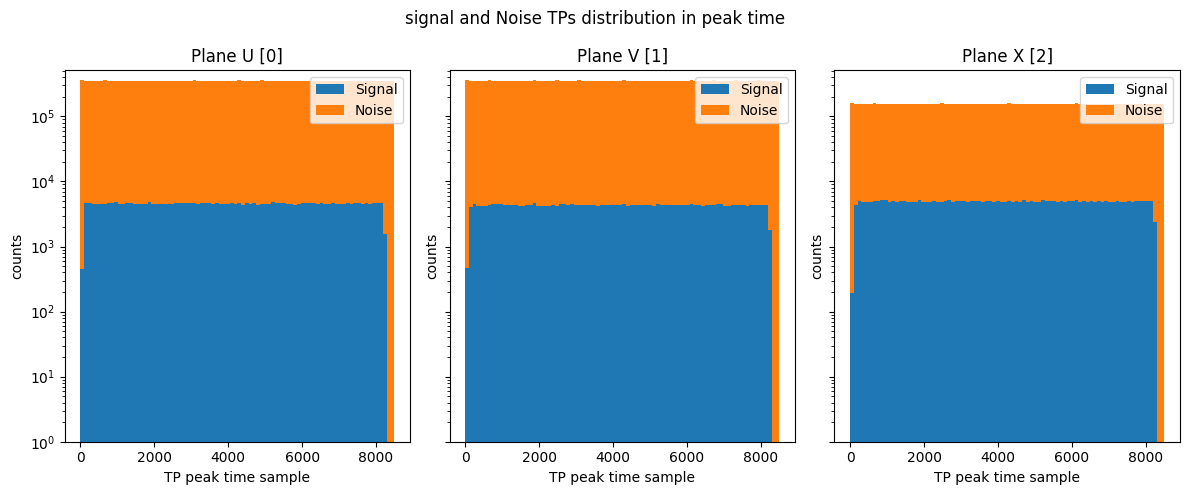

In [22]:
fig = alltp_ana.draw_tp_start_sample_dist()

# Cleaning: removing regions with uneven backtracking efficiency due to WireCell config features

In [25]:
tpw = snn.TPSignalNoisePreSelection(ws.tps[(ws.tps.sample_start >100) & (ws.tps.sample_start <8100)])
tp_ana = snn.TPSignalNoiseAnalyzer(tpw, signal_name='Ar39')

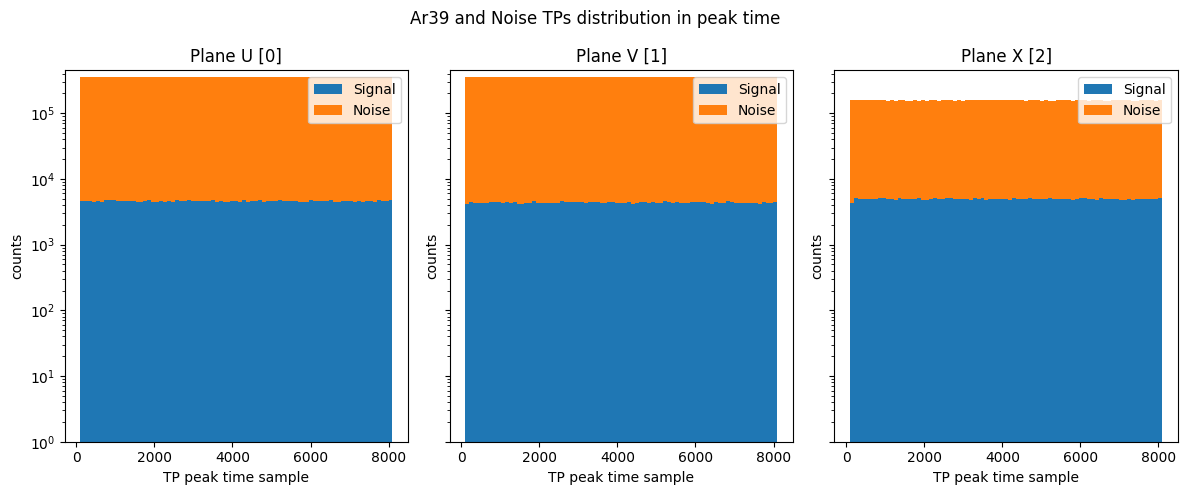

In [26]:
fig = tp_ana.draw_tp_start_sample_dist()


# adcpeak, time-over-threshold and SumADC distribution for Ar39 and noise

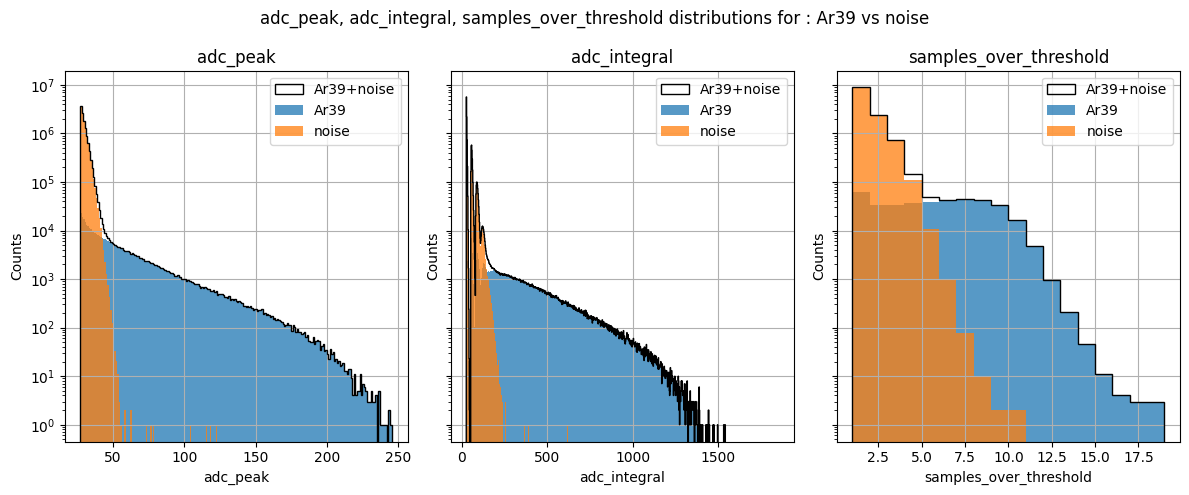

In [40]:
fig = tp_ana.draw_tp_signal_noise_dist()
fig.tight_layout()

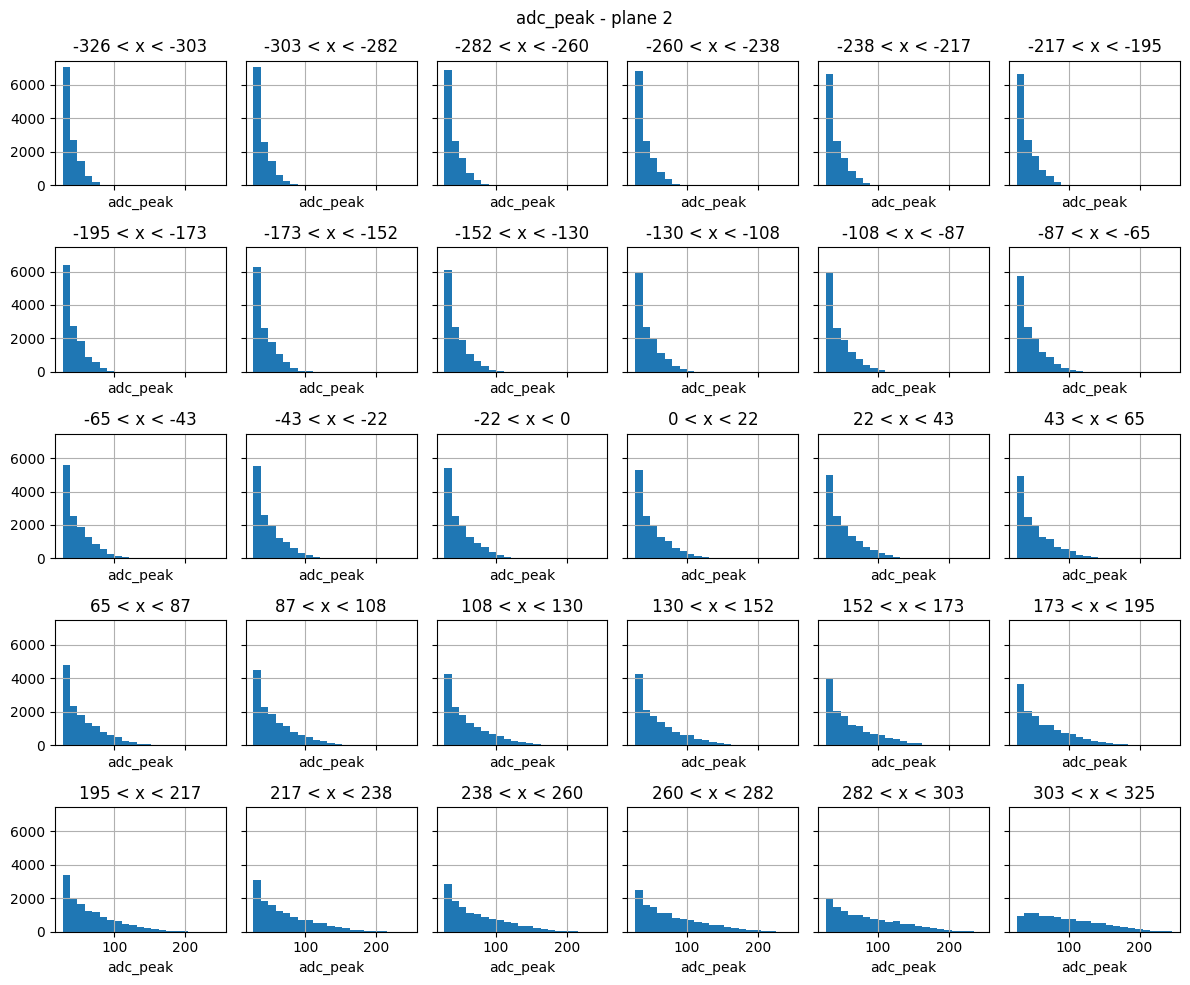

In [41]:
fig = tp_ana.draw_variable_in_drift_grid('adc_peak', downsampling=10, sharex=True, sharey=True, figsize=(12,10))
fig.tight_layout()

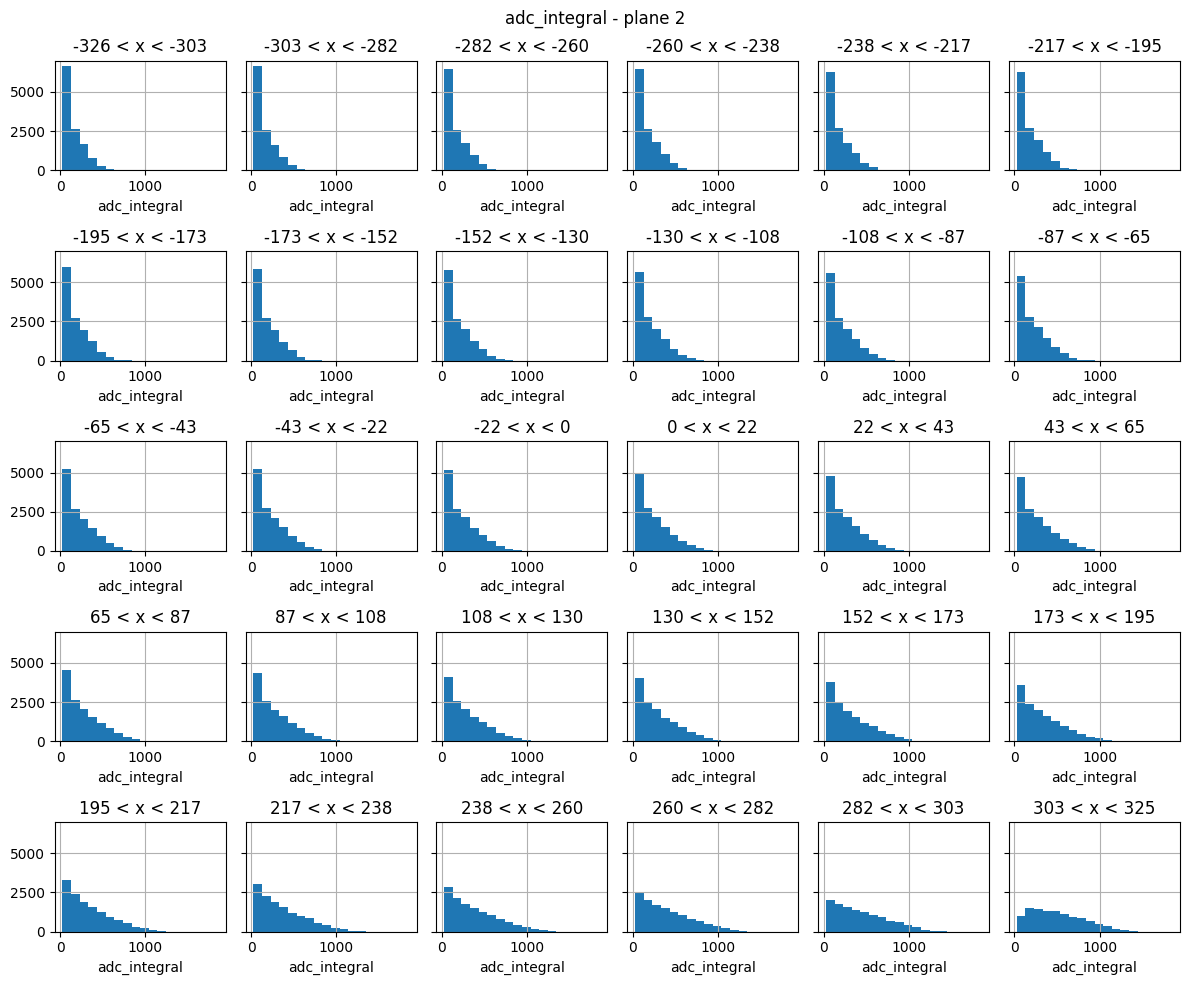

In [42]:
fig = tp_ana.draw_variable_in_drift_grid('adc_integral', downsampling=100, sharey=True, figsize=(12,10))
fig.tight_layout()

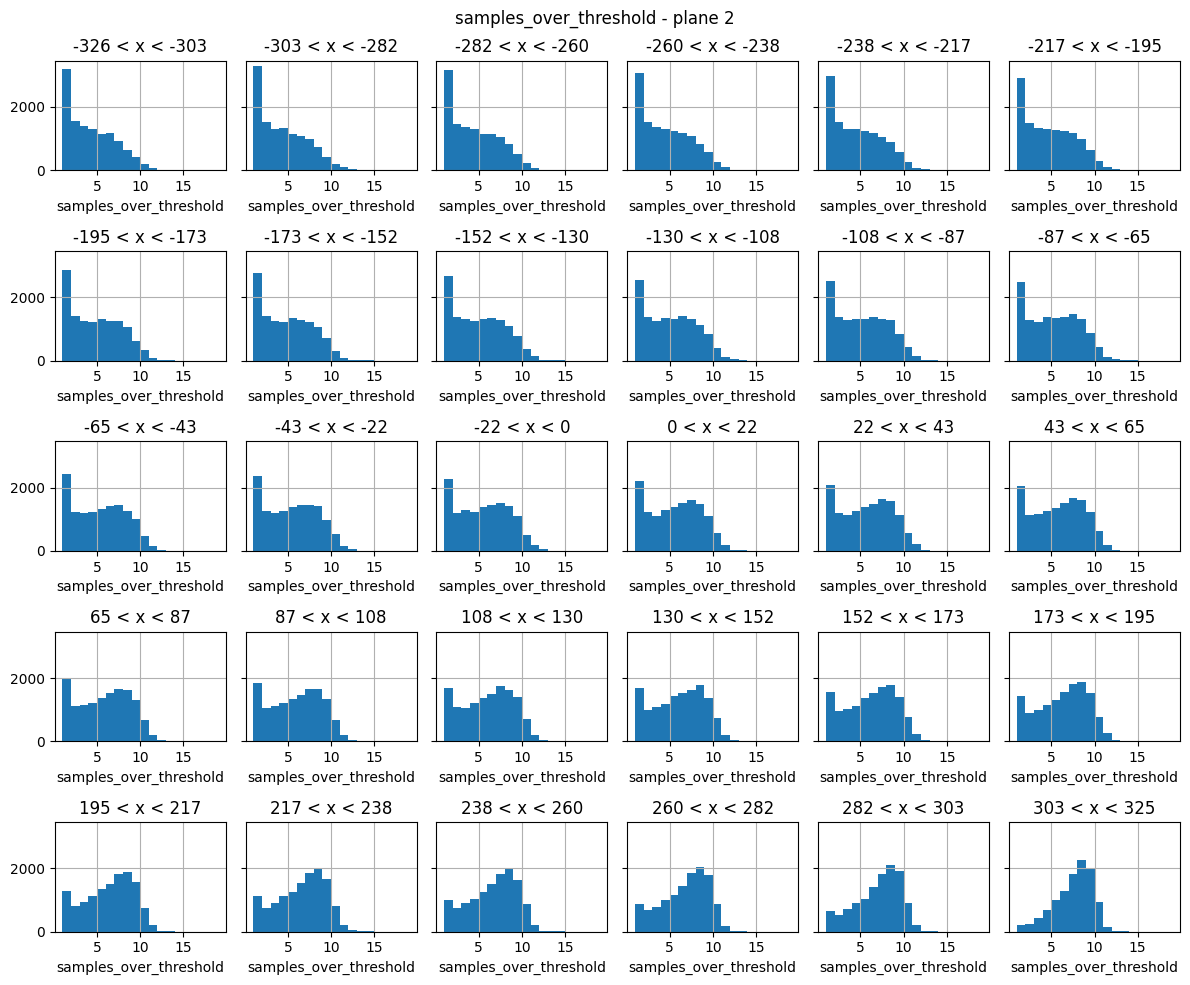

In [43]:
fig = tp_ana.draw_variable_in_drift_grid('samples_over_threshold', downsampling=1, log=False, sharey=True, figsize=(12,10))
fig.tight_layout()

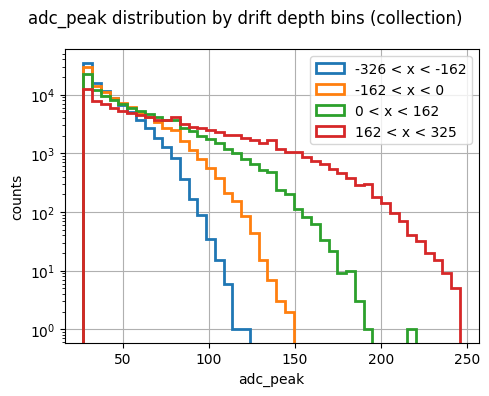

In [44]:
fig = tp_ana.draw_variable_drift_stack('adc_peak', downsampling=5, n_x_bins=4, log=True, figsize=(5,4))
fig.tight_layout()

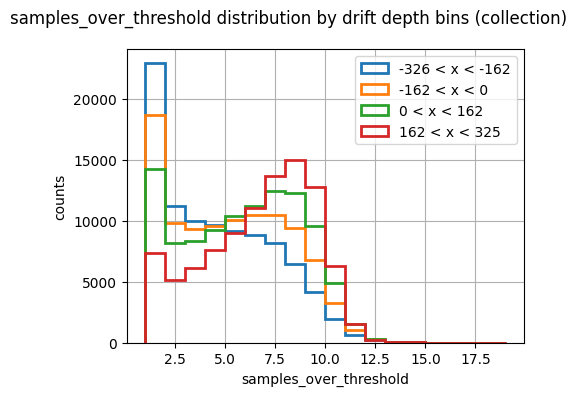

In [45]:
fig = tp_ana.draw_variable_drift_stack('samples_over_threshold', downsampling=1, n_x_bins=4, log=False, figsize=(5,4))
fig.tight_layout()


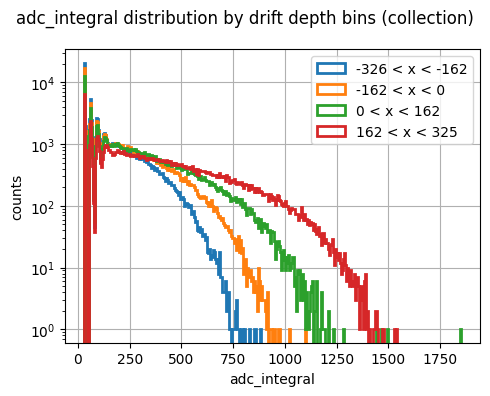

In [46]:
fig = tp_ana.draw_variable_drift_stack('adc_integral', downsampling=5, n_x_bins=4, log=True, figsize=(5,4))
fig.tight_layout()


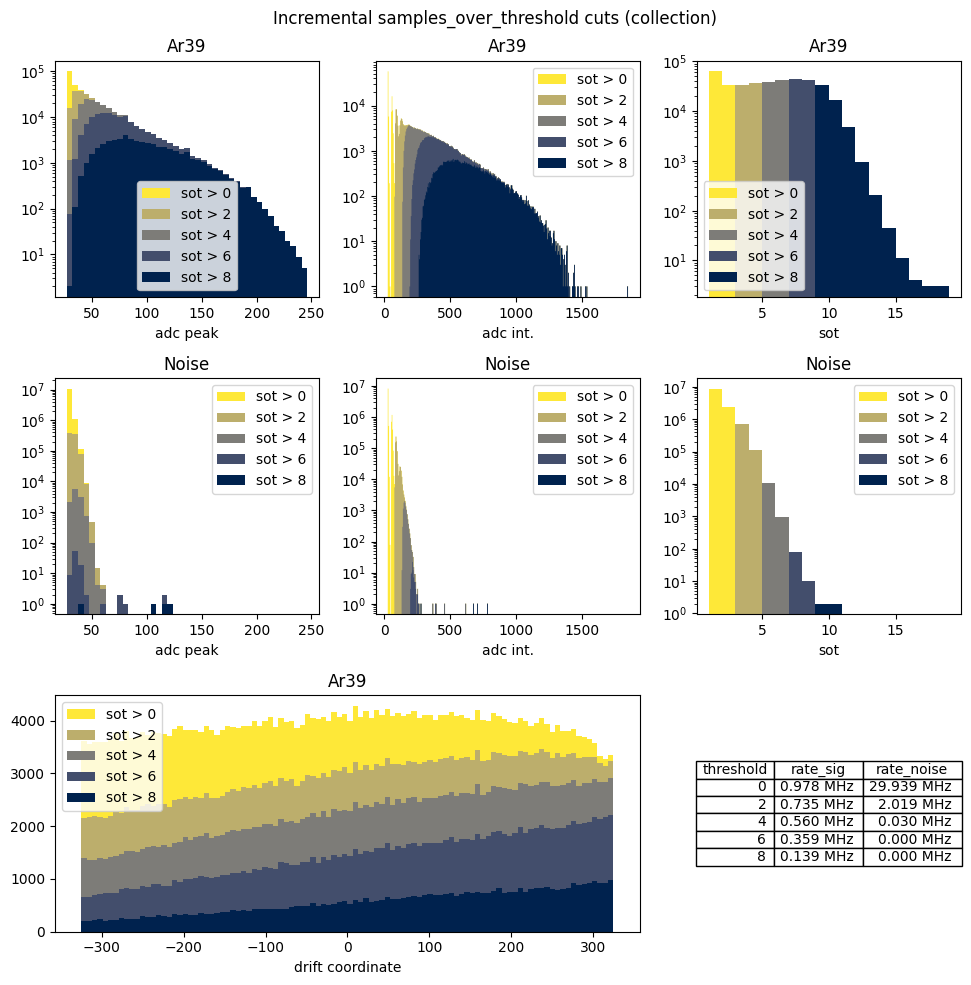

In [47]:
tot_cuts = [t for t in range(0,10,2)]

fig = tp_ana.draw_variable_cut_sequence('samples_over_threshold', tot_cuts, log=True, figsize=(10,10))


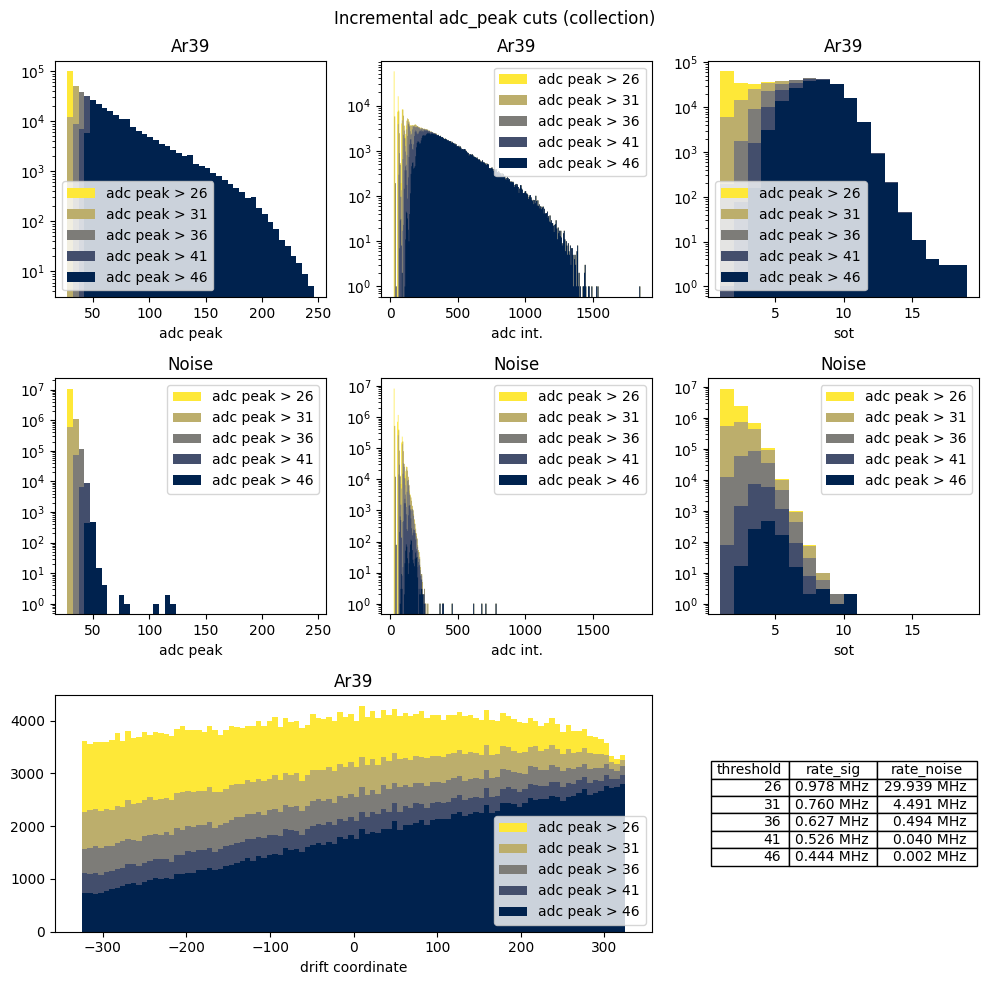

In [48]:
cuts = [t for t in range(26, 50, 5)]

fig = tp_ana.draw_variable_cut_sequence('adc_peak', cuts, log=True, figsize=(10,10))
fig.tight_layout()

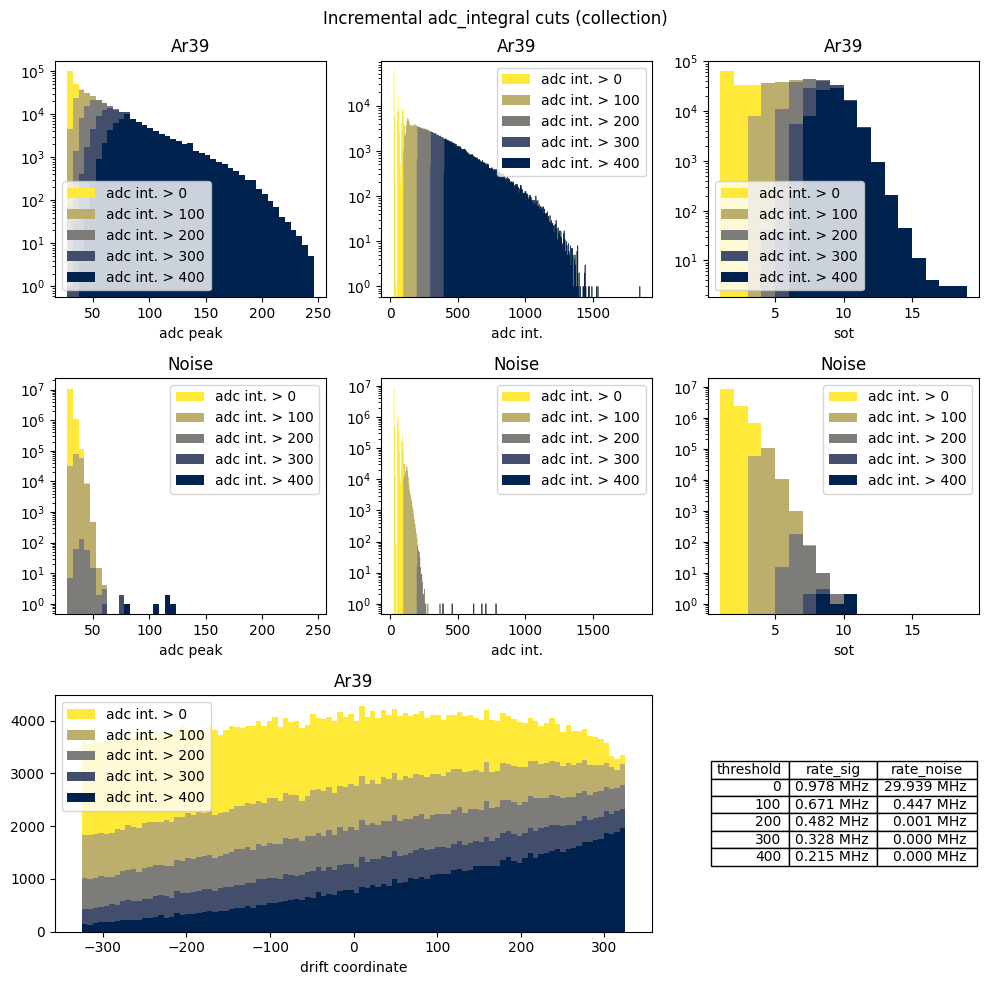

In [49]:
cuts = [t for t in range(0, 500, 100)]

fig = tp_ana.draw_variable_cut_sequence('adc_integral', cuts, figsize=(10,10), log=True)
fig.tight_layout()

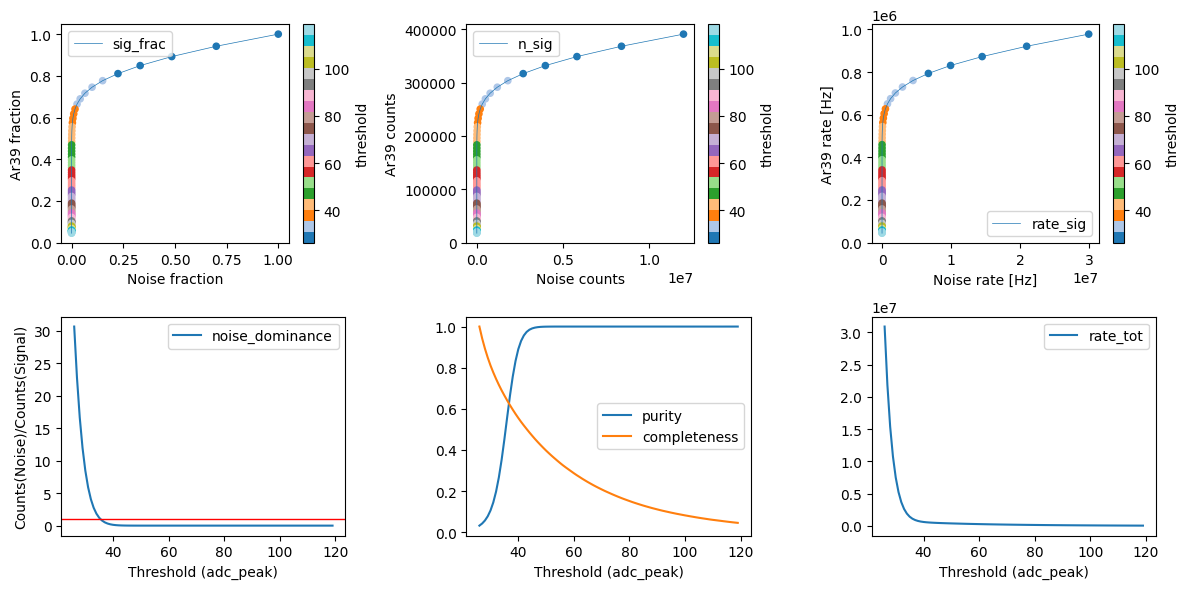

In [50]:
thresholds = [t for t in range(26, 120, 1)]

fig = tp_ana.draw_threshold_scan('adc_peak', thresholds)
fig.tight_layout()

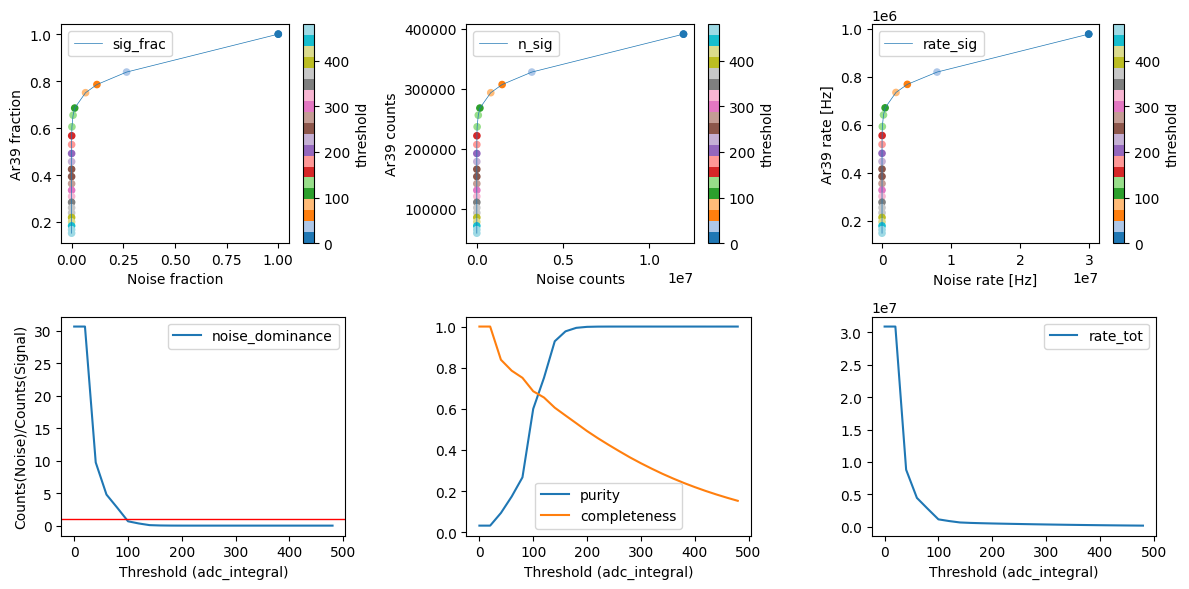

In [51]:
thresholds = [t for t in range(0, 500, 20)]

fig = tp_ana.draw_threshold_scan('adc_integral', thresholds)
fig.tight_layout()

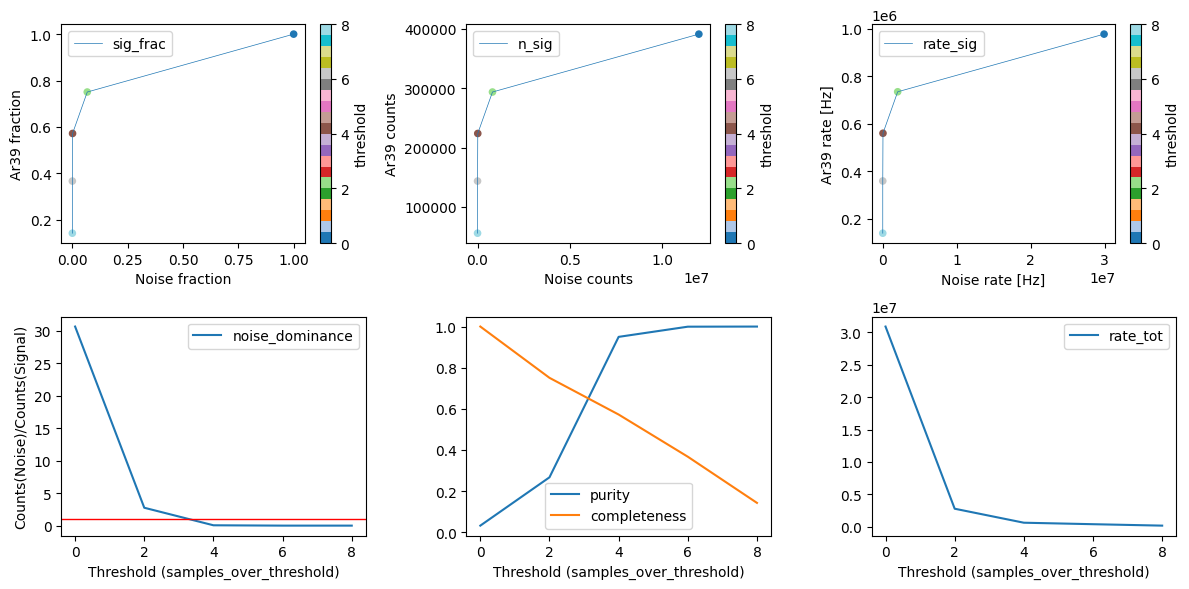

In [39]:
thresholds = [t for t in range(0,10,2)]

fig = tp_ana.draw_threshold_scan('samples_over_threshold', thresholds)
fig.tight_layout()

# Backtracking efficiency

Text(0.5, 0.98, 'adc_peak > 48')

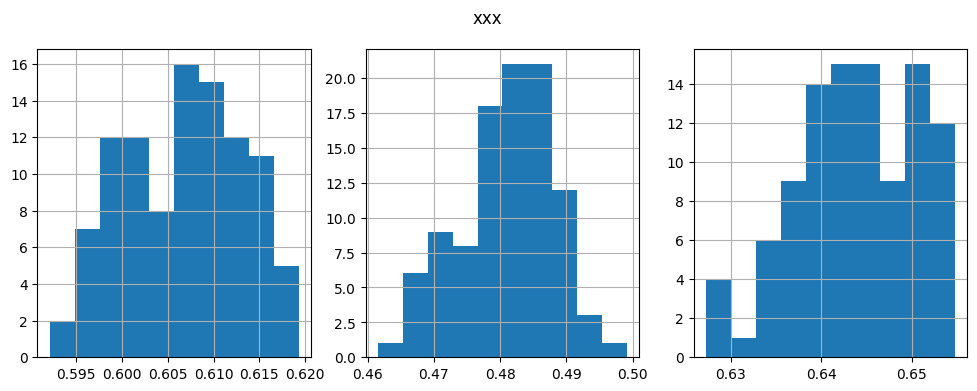

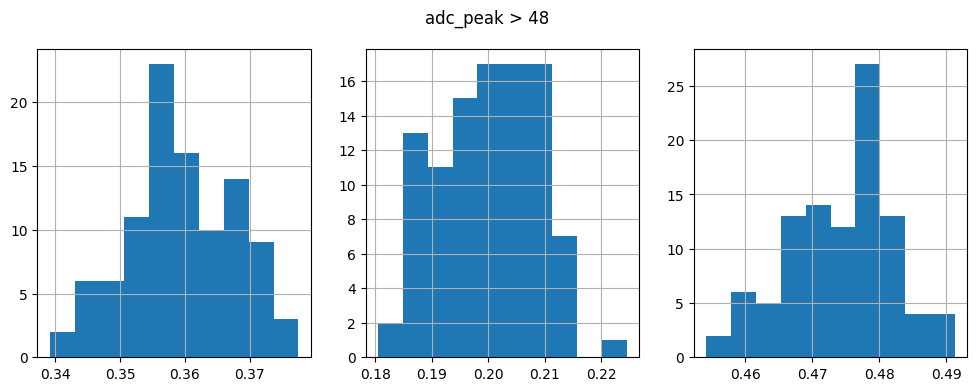

In [62]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
em_0_df = draw_bt_eff_by_plane(ws, 0, axes[0])
em_1_df = draw_bt_eff_by_plane(ws, 1, axes[1])
em_2_df = draw_bt_eff_by_plane(ws, 2, axes[2])
fig.suptitle('xxx')


filter='adc_peak > 48'
fig, axes = plt.subplots(1,3, figsize=(12,4))
em_0_df = draw_bt_eff_by_plane(ws, 0, axes[0], filter)
em_1_df = draw_bt_eff_by_plane(ws, 1, axes[1], filter)
em_2_df = draw_bt_eff_by_plane(ws, 2, axes[2], filter)
fig.suptitle(filter)

# Investigating weird TP and IDES distributions

In [ ]:
weird_ides = ws.ides[ws.ides.time > 8500]
display(weird_ides)
first_ides = ws.ides[ws.ides.time < 100]
display(first_ides)


event       run  subrun  n_ides  channel   time  track_id  \
entry subentry                                                              
0     466           1  20000047       0  308962      108  65350     13338   
      467           1  20000047       0  308962      108  65350     13338   
      468           1  20000047       0  308962      108  65351     13338   
      469           1  20000047       0  308962      108  65351     13338   
      470           1  20000047       0  308962      108  65352     13338   
...               ...       ...     ...     ...      ...    ...       ...   
99    309225      100  20000047       0  309595    41427  65246      6875   
      309226      100  20000047       0  309595    41427  65247      6875   
      309227      100  20000047       0  309595    41427  65248      6875   
      309228      100  20000047       0  309595    41427  65249      6875   
      309229      100  20000047       0  309595    41427  65250      6875   

                mcgen_key  n_electrons    energy           x           y  \
entry subentry                                                             
0     466               0   247.365677  0.012571  276.644745 -659.078369   
      467               0   119.060219  0.010584  276.652069 -659.084656   
      468               0  2060.005859  0.104692  276.644745 -659.078369   
      469               0   731.576538  0.065032  276.652069 -659.084656   
      470               0   726.811401  0.036937  276.644745 -659.078369   
...                   ...          ...       ...         ...         ...   
99    309225            0    52.605354  0.003962   96.971237  593.558716   
      309226            0    51.393204  0.003870   96.971237  593.558716   
      309227            0    27.895889  0.002101   96.971237  593.558716   
      309228            0     8.403118  0.000633   96.971237  593.558716   
      309229            0     1.401907  0.000106   96.971237  593.558716   

                         z  
entry subentry              
0     466       143.752151  
      467       143.750198  
      468       143.752151  
      469       143.750198  
      470       143.752151  
...                    ...  
99    309225    872.858215  
      309226    872.858215  
      309227    872.858215  
      309228    872.858215  
      309229    872.858215  

[3461739 rows x 13 columns]

event       run  subrun  n_ides  channel  time  track_id  \
entry subentry                                                             
0     605           1  20000047       0  308962      131     3     14739   
      606           1  20000047       0  308962      131     4     14739   
      607           1  20000047       0  308962      131     5     14739   
      608           1  20000047       0  308962      131     6     14739   
      609           1  20000047       0  308962      131     7     14739   
...               ...       ...     ...     ...      ...   ...       ...   
99    309187      100  20000047       0  309595    41420     3      8649   
      309196      100  20000047       0  309595    41421     0      8649   
      309197      100  20000047       0  309595    41421     1      8649   
      309198      100  20000047       0  309595    41421     2      8649   
      309199      100  20000047       0  309595    41421     3      8649   

                mcgen_key  n_electrons    energy          x           y  \
entry subentry                                                            
0     605               0     1.620536  0.000209   3.332465 -639.864807   
      606               0     7.838993  0.001009   3.332465 -639.864807   
      607               0    25.072035  0.003228   3.332465 -639.864807   
      608               0    53.056206  0.006830   3.332465 -639.864807   
      609               0    74.318878  0.009567   3.332465 -639.864807   
...                   ...          ...       ...        ...         ...   
99    309187            0    11.216750  0.000727  56.360992  659.764404   
      309196            0  1129.979492  0.072480  56.361008  659.764221   
      309197            0   252.726990  0.016226  56.361004  659.764221   
      309198            0    76.460922  0.004912  56.361004  659.764221   
      309199            0    14.054015  0.000903  56.361004  659.764221   

                         z  
entry subentry              
0     605       145.933273  
      606       145.933273  
      607       145.933273  
      608       145.933273  
      609       145.933273  
...                    ...  
99    309187    870.033447  
      309196    870.033569  
      309197    870.033569  
      309198    870.033569  
      309199    870.033569  

[344887 rows x 13 columns]

In [82]:
from tpvalidator.mcprod.backtracker import BackTrackerPlotter

In [83]:
bt = BackTrackerPlotter(ws, 1)

[1]

1

/Users/ale/Development/dune/trigger-studies/tpvalidator/src/tpvalidator/mcprod/workspace.py:380: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [75]:
tps_ev1 = tpw.query('event==1')
display(tps_ev1.p2)

event       run  subrun  version  flag  detid  channel  \
12048       1  20000047       0        2     0      3      572   
12049       1  20000047       0        2     0      3      572   
12050       1  20000047       0        2     0      3      572   
12051       1  20000047       0        2     0      3      572   
12052       1  20000047       0        2     0      3      572   
...       ...       ...     ...      ...   ...    ...      ...   
721190      1  20000047       0        2     0      3    41471   
721191      1  20000047       0        2     0      3    41471   
721192      1  20000047       0        2     0      3    41471   
721193      1  20000047       0        2     0      3    41471   
721194      1  20000047       0        2     0      3    41471   

        samples_over_threshold  time_start  samples_to_peak  ...  \
12048                        1       28352                0  ...   
12049                        1       62912                0  ...   
12050                        2       89440                0  ...   
12051                        1      123232                0  ...   
12052                        2      136864                0  ...   
...                        ...         ...              ...  ...   
721190                       1      217600                0  ...   
721191                       1      222880                0  ...   
721192                       1      237536                0  ...   
721193                       1      241856                0  ...   
721194                       2      251808                0  ...   

                bt_z  bt_primary_x  bt_primary_y  bt_primary_z  \
12048  -99999.000000 -99999.000000 -99999.000000 -99999.000000   
12049  -99999.000000 -99999.000000 -99999.000000 -99999.000000   
12050  -99999.000000 -99999.000000 -99999.000000 -99999.000000   
12051  -99999.000000 -99999.000000 -99999.000000 -99999.000000   
12052  -99999.000000 -99999.000000 -99999.000000 -99999.000000   
...              ...           ...           ...           ...   
721190 -99999.000000 -99999.000000 -99999.000000 -99999.000000   
721191 -99999.000000 -99999.000000 -99999.000000 -99999.000000   
721192 -99999.000000 -99999.000000 -99999.000000 -99999.000000   
721193    896.014648   -182.265442    624.720398    896.014648   
721194 -99999.000000 -99999.000000 -99999.000000 -99999.000000   

        bt_truth_block_id  bt_generator_name  time_peak  sample_start  \
12048              -99999                         28384           886   
12049              -99999                         62944          1966   
12050              -99999                         89504          2795   
12051              -99999                        123264          3851   
12052              -99999                        136928          4277   
...                   ...                ...        ...           ...   
721190             -99999                        217632          6800   
721191             -99999                        222912          6965   
721192             -99999                        237568          7423   
721193                  0       Ar39GenInLAr     241888          7558   
721194             -99999                        251872          7869   

        sample_peak  bt_is_signal  
12048           887         False  
12049          1967         False  
12050          2797         False  
12051          3852         False  
12052          4279         False  
...             ...           ...  
721190         6801         False  
721191         6966         False  
721192         7424         False  
721193         7559          True  
721194         7871         False  

[121679 rows x 32 columns]

In [86]:
tps_ev1.p2.query("adc_peak >48 & bt_is_signal == 0 ")

event       run  subrun  version  flag  detid  channel  \
284846      1  20000047       0        2     0      3    16229   
346285      1  20000047       0        2     0      3    19852   

        samples_over_threshold  time_start  samples_to_peak  ...     bt_z  \
284846                       3      127232                1  ... -99999.0   
346285                       4       41344                1  ... -99999.0   

        bt_primary_x  bt_primary_y  bt_primary_z  bt_truth_block_id  \
284846      -99999.0      -99999.0      -99999.0             -99999   
346285      -99999.0      -99999.0      -99999.0             -99999   

        bt_generator_name  time_peak  sample_start  sample_peak  bt_is_signal  
284846                        127328          3976         3979         False  
346285                         41472          1292         1296         False  

[2 rows x 32 columns]

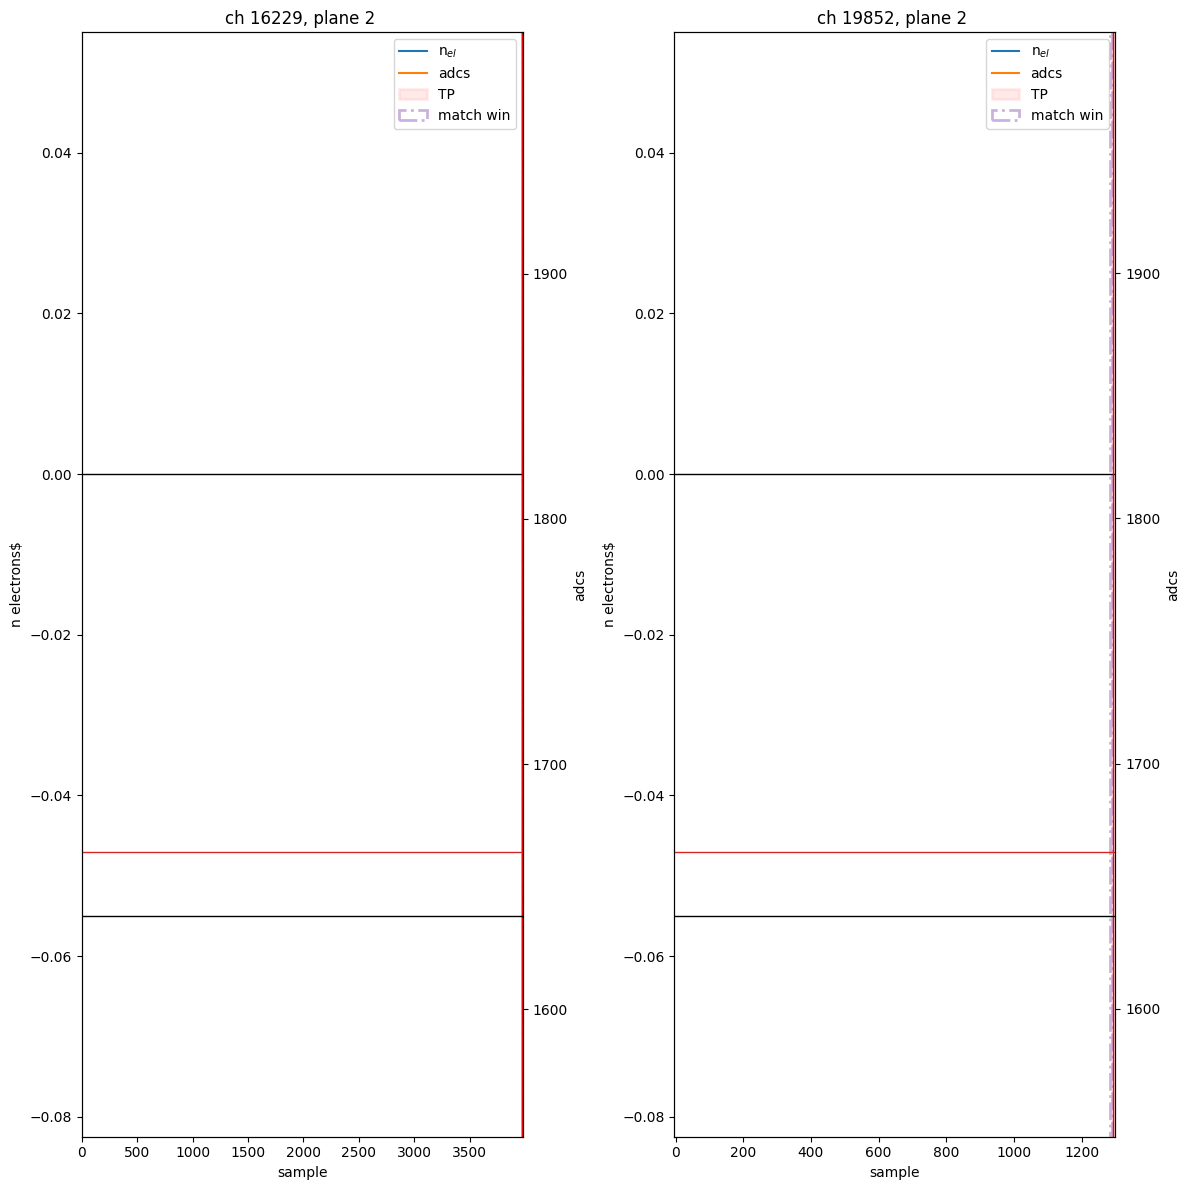

In [85]:
bt.plot_tps_vs_ides(tps_ev1.p2.query("adc_peak >48 & bt_is_signal == 0 "), figsize=(12,12))


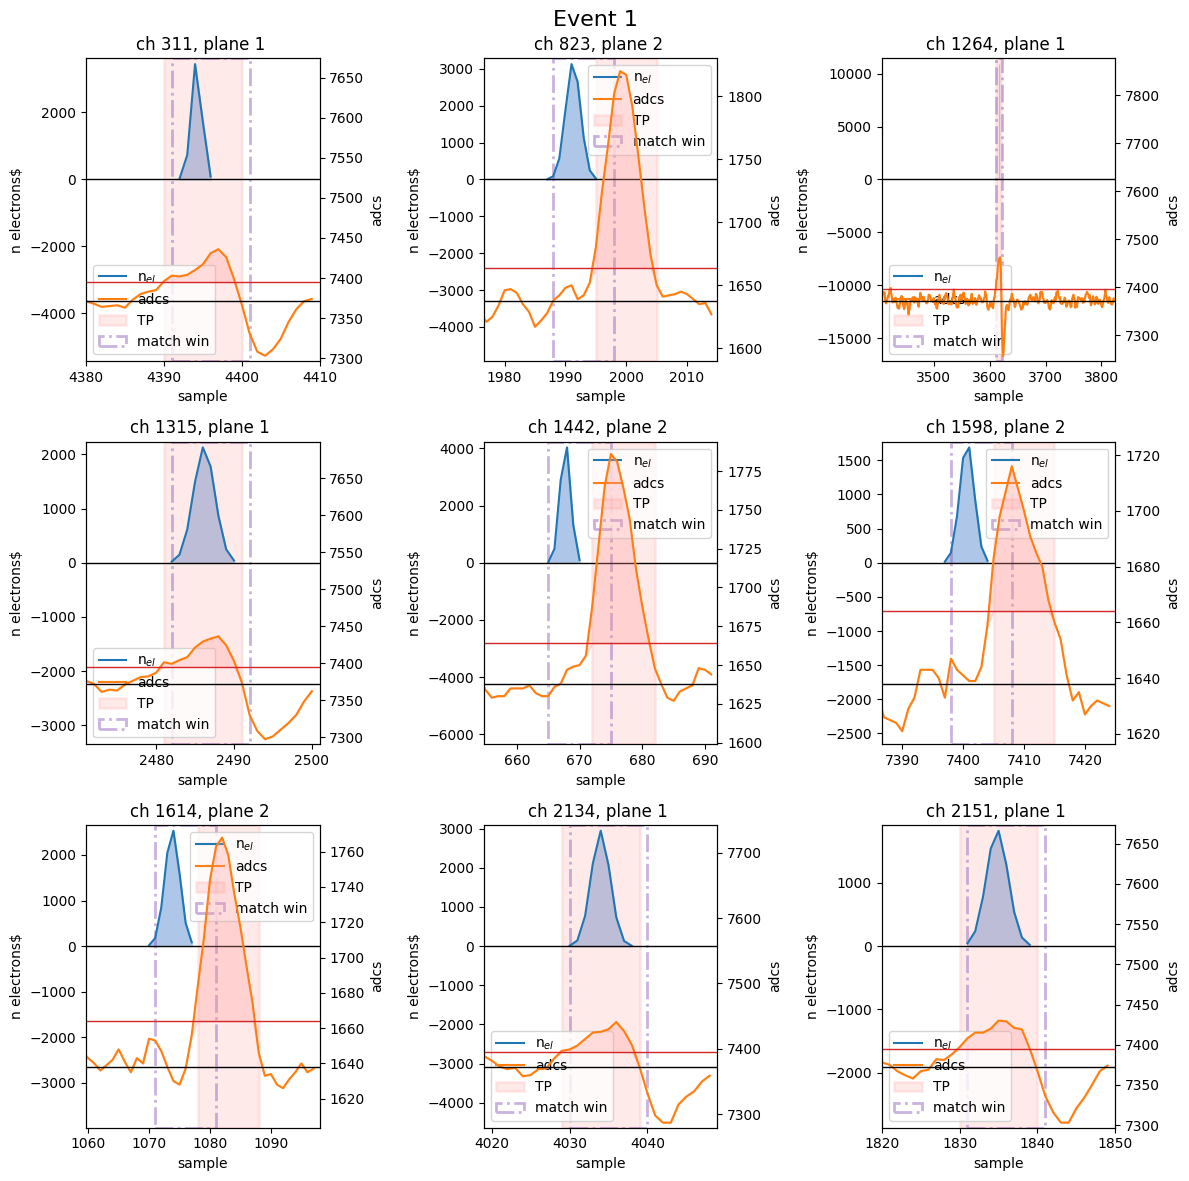

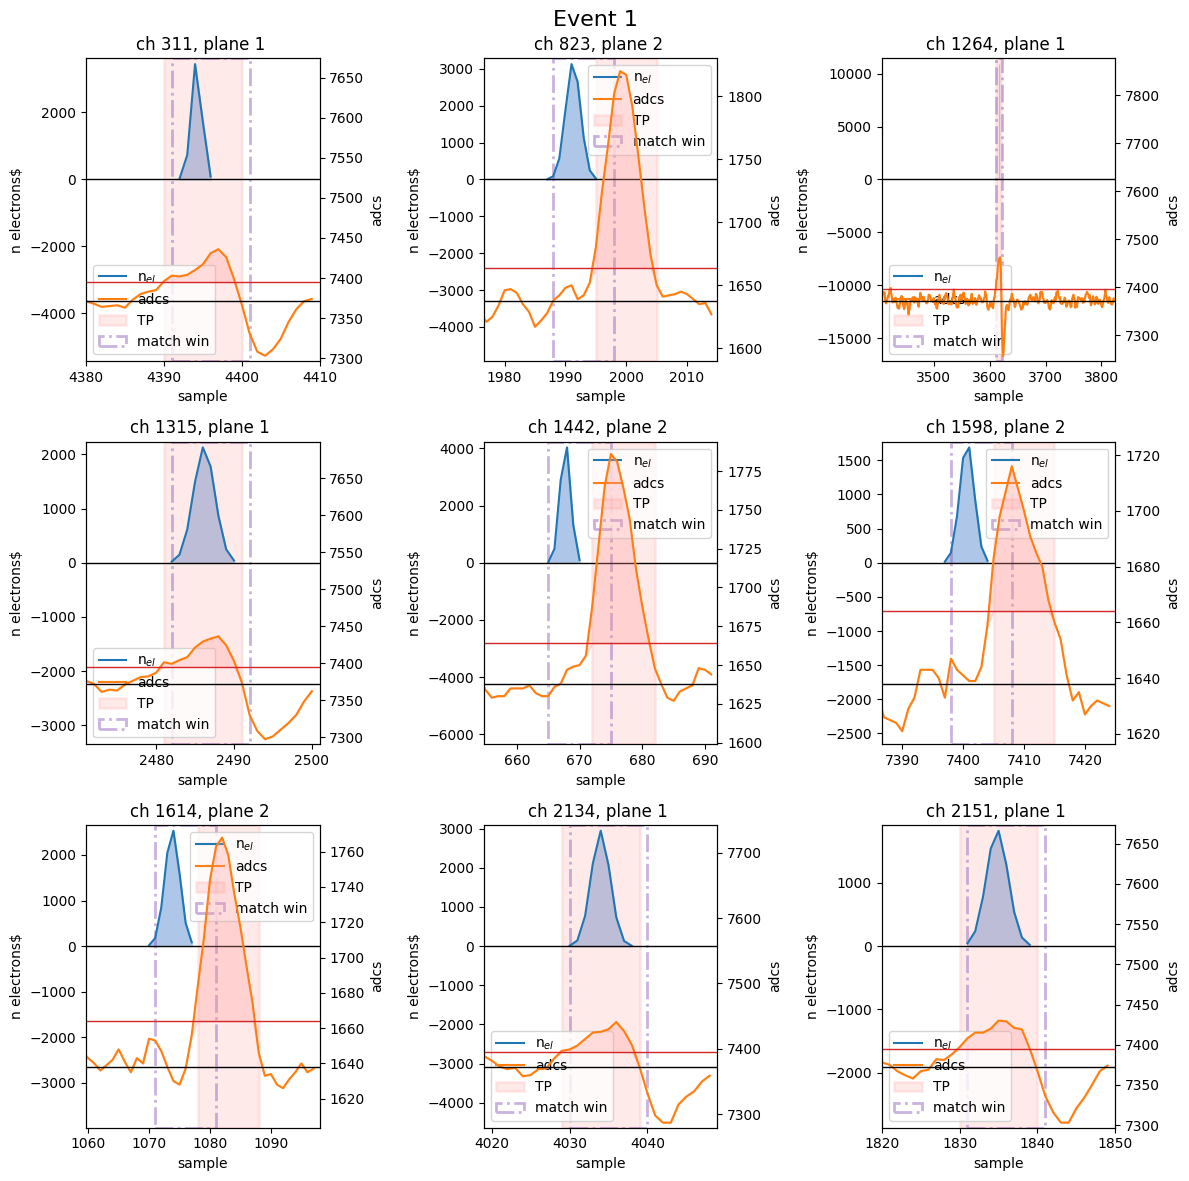

In [ ]:
bt.plot_tps_vs_ides(bt.inspect_tps.query('TP_TOT == 10').iloc[:9], figsize=(12,12))


# Impact of tighter adcpeak cuts

In [64]:
tp_clean = tpw.query('adc_peak > 30')
tp_clean_ana = snn.TPSignalNoiseAnalyzer(tp_clean, readout_window=8000)

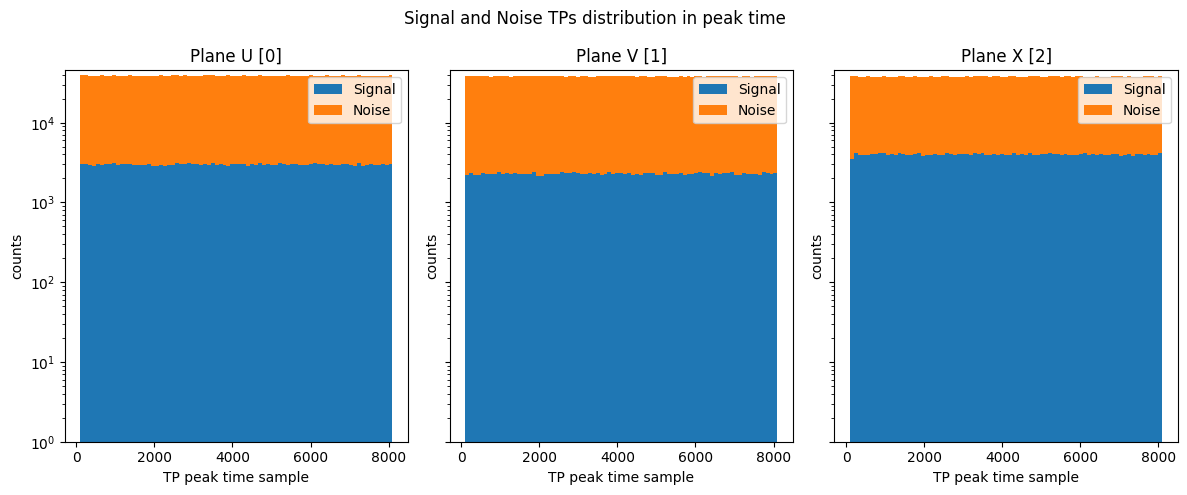

In [65]:
fig = tp_clean_ana.draw_tp_start_sample_dist()


In [66]:
simulated_time = len(tp_clean.all.event.unique())*8000*0.5e-6
df_scan = tp_clean_ana.do_threshold_scan(2, 'adc_peak', [35, 38, 40, 41, 42, 44, 46])
display(df_scan)

threshold   n_sig  n_noise  rate_sig  rate_noise   n_tot   rate_tot  \
0         35  259832   314981  649580.0    787452.5  574813  1437032.5   
1         38  233016    75059  582540.0    187647.5  308075   770187.5   
2         40  217143    26863  542857.5     67157.5  244006   610015.0   
3         41  209768    15829  524420.0     39572.5  225597   563992.5   
4         42  202835     9196  507087.5     22990.0  212031   530077.5   
5         44  189617     2959  474042.5      7397.5  192576   481440.0   
6         46  177210      922  443025.0      2305.0  178132   445330.0   

   sig_frac  noise_frac  
0  0.819827    0.117284  
1  0.735217    0.027948  
2  0.685134    0.010002  
3  0.661864    0.005894  
4  0.639989    0.003424  
5  0.598284    0.001102  
6  0.559137    0.000343

In [67]:
df_scan['noise_rate_per_chan'] = df_scan.n_noise/simulated_time/14016
display(df_scan)

threshold   n_sig  n_noise  rate_sig  rate_noise   n_tot   rate_tot  \
0         35  259832   314981  649580.0    787452.5  574813  1437032.5   
1         38  233016    75059  582540.0    187647.5  308075   770187.5   
2         40  217143    26863  542857.5     67157.5  244006   610015.0   
3         41  209768    15829  524420.0     39572.5  225597   563992.5   
4         42  202835     9196  507087.5     22990.0  212031   530077.5   
5         44  189617     2959  474042.5      7397.5  192576   481440.0   
6         46  177210      922  443025.0      2305.0  178132   445330.0   

   sig_frac  noise_frac  noise_rate_per_chan  
0  0.819827    0.117284            56.182399  
1  0.735217    0.027948            13.388092  
2  0.685134    0.010002             4.791488  
3  0.661864    0.005894             2.823380  
4  0.639989    0.003424             1.640268  
5  0.598284    0.001102             0.527790  
6  0.559137    0.000343             0.164455

In [68]:
df_scan = tp_clean_ana.do_threshold_scan(0, 'adc_peak', [34, 35, 38, 40, 41, 42, 44, 46, 48])
df_scan['noise_rate_per_chan'] = df_scan.n_noise/simulated_time/13278
display(df_scan)


threshold   n_sig  n_noise  rate_sig  rate_noise   n_tot   rate_tot  \
0         34  192909   620508  482272.5   1551270.0  813417  2033542.5   
1         35  183612   413940  459030.0   1034850.0  597552  1493880.0   
2         38  159122   114908  397805.0    287270.0  274030   685075.0   
3         40  144802    46606  362005.0    116515.0  191408   478520.0   
4         41  138236    29094  345590.0     72735.0  167330   418325.0   
5         42  132120    17993  330300.0     44982.5  150113   375282.5   
6         44  120454     6787  301135.0     16967.5  127241   318102.5   
7         46  109754     2578  274385.0      6445.0  112332   280830.0   
8         48  100302     1000  250755.0      2500.0  101302   253255.0   

   sig_frac  noise_frac  noise_rate_per_chan  
0  0.815414    0.218795           116.830095  
1  0.776116    0.145958            77.937189  
2  0.672598    0.040517            21.635035  
3  0.612069    0.016434             8.775041  
4  0.584315    0.010259             5.477858  
5  0.558463    0.006344             3.387747  
6  0.509151    0.002393             1.277866  
7  0.463923    0.000909             0.485389  
8  0.423970    0.000353             0.188281

In [73]:
df_scan = tp_clean_ana.do_threshold_scan(1, 'adc_peak', [34, 35, 38, 40, 41, 42, 44, 46, 48])
df_scan['noise_rate_per_chan'] = df_scan.n_noise/simulated_time/13278
display(df_scan)


threshold   n_sig  n_noise  rate_sig  rate_noise   n_tot   rate_tot  \
0         34  132808   621787  332020.0   1554467.5  754595  1886487.5   
1         35  123189   414717  307972.5   1036792.5  537906  1344765.0   
2         38   99090   115984  247725.0    289960.0  215074   537685.0   
3         40   85886    47017  214715.0    117542.5  132903   332257.5   
4         41   79938    29605  199845.0     74012.5  109543   273857.5   
5         42   74276    18618  185690.0     46545.0   92894   232235.0   
6         44   64415     7190  161037.5     17975.0   71605   179012.5   
7         46   55729     2826  139322.5      7065.0   58555   146387.5   
8         48   48287     1261  120717.5      3152.5   49548   123870.0   

   sig_frac  noise_frac  noise_rate_per_chan  
0  0.732213    0.219028           117.070907  
1  0.679180    0.146086            78.083484  
2  0.546315    0.040856            21.837626  
3  0.473517    0.016562             8.852425  
4  0.440724    0.010429             5.574070  
5  0.409507    0.006558             3.505423  
6  0.355140    0.002533             1.353743  
7  0.307252    0.000995             0.532083  
8  0.266222    0.000444             0.237423